In [1]:
import pprint
import shutil
from pathlib import Path

import tifffile
from careamics_portfolio import PortfolioManager
from matplotlib.pyplot import imshow

from careamics_restoration.engine import Engine

/localfast/mambaforge/envs/cmcs_lf/lib/python3.11/site-packages/bioimageio/spec/shared/_resolve_source.py:437: CacheWarning: found cached /tmp/igor.zubarev/bioimageio_cache/https/raw.githubusercontent.com/bioimage-io/bioimage.io/main/site.config.json. Skipping download of https://raw.githubusercontent.com/bioimage-io/bioimage.io/main/site.config.json.
  warnings.warn(f"found cached {local_path}. Skipping download of {uri}.", category=CacheWarning)
/localfast/mambaforge/envs/cmcs_lf/lib/python3.11/site-packages/bioimageio/spec/shared/_resolve_source.py:437: CacheWarning: found cached /tmp/igor.zubarev/bioimageio_cache/https/bioimage-io.github.io/collection-bioimage-io/collection.json. Skipping download of https://bioimage-io.github.io/collection-bioimage-io/collection.json.
  warnings.warn(f"found cached {local_path}. Skipping download of {uri}.", category=CacheWarning)


### Import Dataset Portfolio

In [2]:
# Explore portfolio
portfolio = PortfolioManager()
print(portfolio.denoising)

denoising datasets: ['N2V_BSD68', 'N2V_SEM', 'N2V_RGB', 'Flywing', 'Convallaria']


In [3]:
# Download files
root_path = Path("./data")
files = portfolio.denoising.N2V_SEM.download(root_path)
print(f"List of downloaded files: {files}")

List of downloaded files: ['/home/igor.zubarev/projects/caremics/examples/2D/data/denoising-N2V_SEM.unzip/train.tif', '/home/igor.zubarev/projects/caremics/examples/2D/data/denoising-N2V_SEM.unzip/validation.tif']


### Visualize training data

Train image shape: (2500, 1690)


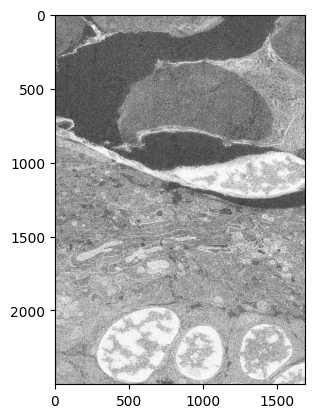

In [4]:
# Load images
train_image = tifffile.imread(files[0])
print(f"Train image shape: {train_image.shape}")
imshow(train_image, cmap="gray")

### Visualize validation data

Validation image shape: (471, 1690)


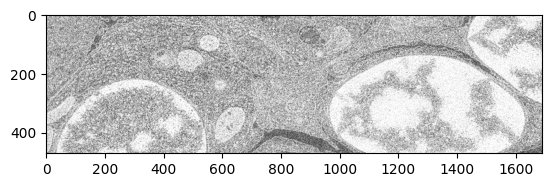

In [5]:
val_image = tifffile.imread(files[1])
print(f"Validation image shape: {val_image.shape}")
imshow(val_image, cmap="gray")

In [6]:
data_path = Path(root_path / "n2v_sem")
train_path = data_path / "train"
val_path = data_path / "val"

train_path.mkdir(parents=True, exist_ok=True)
val_path.mkdir(parents=True, exist_ok=True)

shutil.copy(root_path / files[0], train_path / "train_image.tif")
shutil.copy(root_path / files[1], val_path / "val_image.tif")

PosixPath('data/n2v_sem/val/val_image.tif')

### Initialize the Engine

Engine contains the dataloading pipeline and the model training logic. We'll initialize the engine with the config file, but it can also be initialized from a pre-trained checkpoint.

Please take as look at the [documentation](https://careamics.github.io) to see the full list of parameters and configuration options

In [13]:
engine = Engine(config_path="n2v_2D_SEM.yml")

Engine initialized from configuration


### Visualize training configuration

In [14]:
pprint.PrettyPrinter(indent=2).pprint(engine.cfg.model_dump(exclude_optionals=False))

{ 'algorithm': { 'is_3D': False,
                 'loss': 'n2v',
                 'masked_pixel_percentage': 0.2,
                 'masking_strategy': <MaskingStrategies.DEFAULT: 'default'>,
                 'model': 'UNet',
                 'model_parameters': {'depth': 2, 'num_channels_init': 32},
                 'roi_size': 11},
  'data': {'axes': 'YX', 'data_format': 'tif', 'in_memory': False},
  'experiment_name': 'N2V_SEM',
  'training': { 'amp': {'init_scale': 1024, 'use': False},
                'augmentation': True,
                'batch_size': 128,
                'lr_scheduler': { 'name': 'ReduceLROnPlateau',
                                  'parameters': {'factor': 0.5}},
                'num_epochs': 100,
                'num_workers': 4,
                'optimizer': {'name': 'Adam', 'parameters': {'lr': 0.0004}},
                'patch_size': [64, 64],
                'use_wandb': False},
  'working_directory': 'n2v_sem'}


### Run training 

We need to specify the paths to training and validation data

In [15]:
train_stats, val_stats = engine.train(train_path=train_path, val_path=val_path)

Calculated mean and std for 1 images
Mean: 39216.046875, std: 18678.18359375
Extracted 216 patches from input array.
Starting training for 100 epochs


Epoch: 1/100


Estimating dataset size ▓ --->- ▒, tile No. 9 - 4s 433ms/step - train_loss: 0.8604 - val loss: 0.8506 - lr: 4.0000e-04

Saved checkpoint to /home/igor.zubarev/projects/caremics/examples/2D/n2v_sem/N2V_SEM_best.pth


Epoch: 2/100
Estimating dataset size ▓ --->- ▒, tile No. 9 - 4s 411ms/step - train_loss: 0.6895 - val loss: 0.6318 - lr: 4.0000e-04

Saved checkpoint to /home/igor.zubarev/projects/caremics/examples/2D/n2v_sem/N2V_SEM_best.pth


Epoch: 3/100
Estimating dataset size ▓ --->- ▒, tile No. 9 - 5s 530ms/step - train_loss: 0.6558 - val loss: 0.5620 - lr: 4.0000e-04

Saved checkpoint to /home/igor.zubarev/projects/caremics/examples/2D/n2v_sem/N2V_SEM_best.pth


Epoch: 4/100
Estimating dataset size ▓ --->- ▒, tile No. 9 - 4s 435ms/step - train_loss: 0.6328 - val loss: 0.5806 - lr: 4.0000e-04

Saved checkpoint to /home/igor.zubarev/projects/caremics/examples/2D/n2v_sem/N2V_SEM_latest.pth


Epoch: 5/100
Estimating dataset size ▓ ----- ▒, tile No. 0 - 0s 0s/step

Training interrupted


### Visualize statistics

In [ ]:
import matplotlib.pyplot as plt

plt.plot([next(iter(d.values())) for d in train_stats], label="Train loss")
plt.plot([next(iter(d.values())) for d in val_stats], label="Validation loss")
plt.legend(loc="best")
plt.xlabel("Epoch")

### Run prediction

We need to specify the path to the data we want to denoise

In [ ]:
preds = engine.predict(input=train_path, tile_shape=[128, 128], overlaps=[48, 48])

### Visualize the prediction

In [ ]:
imshow(preds.squeeze(), cmap="gray")

### Export to bioimage.io

In [ ]:
engine.save_as_bioimage(engine.cfg.experiment_name + "bioimage.zip")